# GoogLeNet

## Import

In [1]:
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras
import tensorflow_datasets as tfds

## GoogLeNet

### Inception module

In [2]:
def inception(layer, filter_list, name):
    branch_1_filters, branch_2_1_filters, branch_2_2_filters, branch_3_1_filters, branch_3_2_filters, branch_4_2_filters = filter_list
    
    branch_1 = keras.layers.Conv2D(filters=branch_1_filters,
                                   kernel_size=(1,1),
                                   strides=1,
                                   padding='same',
                                   activation='relu',
                                   kernel_initializer='he_normal',
                                   name=f'Inception_{name}_conv_1_1')(layer)
    
    branch_2_1 = keras.layers.Conv2D(filters=branch_2_1_filters,
                                   kernel_size=(1,1),
                                   strides=1,
                                   padding='same',
                                   activation='relu',
                                   kernel_initializer='he_normal',
                                   name=f'Inception_{name}_conv_2_1')(layer)
    branch_2_2 = keras.layers.Conv2D(filters=branch_2_2_filters,
                                   kernel_size=(3,3),
                                   strides=1,
                                   padding='same',
                                   activation='relu',
                                   kernel_initializer='he_normal',
                                   name=f'Inception_{name}_conv_2_2')(branch_2_1)
    
    branch_3_1 = keras.layers.Conv2D(filters=branch_3_1_filters,
                                   kernel_size=(1,1),
                                   strides=1,
                                   padding='same',
                                   activation='relu',
                                   kernel_initializer='he_normal',
                                   name=f'Inception_{name}_conv_3_1')(layer)
    branch_3_2 = keras.layers.Conv2D(filters=branch_3_2_filters,
                                   kernel_size=(5,5),
                                   strides=1,
                                   padding='same',
                                   activation='relu',
                                   kernel_initializer='he_normal',
                                   name=f'Inception_{name}_conv_3_2')(branch_3_1)
    
    branch_4_1 = keras.layers.MaxPool2D((3,3), strides=1, padding='same', name=f'Inception_{name}_max_pool')(layer)
    branch_4_2 = keras.layers.Conv2D(filters=branch_4_2_filters,
                                   kernel_size=(1,1),
                                   strides=1,
                                   padding='same',
                                   activation='relu',
                                   kernel_initializer='he_normal',
                                   name=f'Inception_{name}_conv_4_2')(branch_4_1)
    
    depth_concat = keras.layers.concatenate([branch_1, branch_2_2, branch_3_2, branch_4_2])
    
    return depth_concat

### auxiliary network

In [3]:
def auxiliary_classifer(layer, num_classes, name):
    AP = keras.layers.AveragePooling2D((5,5), strides=3, padding='valid', name=f'Auxilary_AP_{name}')(layer)
    conv_1 = keras.layers.Conv2D(filters=128,
                                 kernel_size=(1,1),
                                 strides=1,
                                 padding='same',
                                 activation='relu',
                                 name=f'Auxilary_Conv_{name}')(AP)
    flatten = keras.layers.Flatten(name=f'Auxilary_Flatten_{name}')(conv_1)
    fc_1 = keras.layers.Dense(1024, activation='relu', name=f'Auxilary_FC_{name}')(flatten)
    dropout = keras.layers.Dropout(0.7, name=f'Auxilary_Dropout_{name}')(fc_1)
    fc_2 = keras.layers.Dense(num_classes, activation='softmax', name=f'Auxilary_Softmax_{name}')(dropout)
    
    return fc_2

### Build GoogLeNet

In [4]:
def build_GoogLeNet(input_shape=(224, 224, 3),
                    num_classes=1000):
    input_layer = keras.layers.Input(shape=input_shape, name='Input')
    
    conv_1 = keras.layers.Conv2D(filters=64,
                                 kernel_size=(7,7),
                                 strides=2,
                                 padding='same',
                                 activation='relu',
                                 name='Conv_1')(input_layer)
    pool_1 = keras.layers.MaxPool2D((3,3), strides=2, padding='same', name='Max_Pool_1')(conv_1)
    lrn_1 = tf.nn.local_response_normalization(pool_1, name='LRN')
    
    conv_2 = keras.layers.Conv2D(filters=64,
                                 kernel_size=(1,1),
                                 strides=1,
                                 padding='valid',
                                 activation='relu',
                                 name='Conv_2')(lrn_1)
    conv_3 = keras.layers.Conv2D(filters=192,
                                 kernel_size=(3,3),
                                 strides=1,
                                 padding='same',
                                 activation='relu',
                                 name='Conv_3')(conv_2)
    lrn_2 = tf.nn.local_response_normalization(conv_3, name='LRN')
    pool_2 = keras.layers.MaxPool2D((3,3), strides=2, padding='same', name='Max_Pool_2')(lrn_2)
    
    inception_3a = inception(pool_2, [64, 96, 128, 16, 32, 32], '3a')
    inception_3b = inception(inception_3a, [128, 128, 192, 32, 96, 64], '3b')
    pool_3 = keras.layers.MaxPool2D((3,3), strides=2, padding='same', name='Max_Pool_3')(inception_3b)
    
    inception_4a = inception(pool_3, [192, 96, 208, 16, 48, 64], '4a')
    auxiliary_classifer_4a = auxiliary_classifer(inception_4a, num_classes, '4a')
    inception_4b = inception(inception_4a, [160, 112, 224, 24, 64, 64], '4b')
    inception_4c = inception(inception_4b, [128, 128, 256, 24, 64, 64], '4c')
    inception_4d = inception(inception_4c, [112, 144, 288, 32, 64, 64], '4d')
    auxiliary_classifer_4d = auxiliary_classifer(inception_4d, num_classes, '4d')
    inception_4e = inception(inception_4d, [256, 160, 320, 32, 128, 128], '4e')
    pool_4 = keras.layers.MaxPool2D((3,3), strides=2, padding='same', name='Max_Pool_4')(inception_4e)    
    
    inception_5a = inception(pool_4, [256, 160, 320, 32, 128, 128], '5a')
    inception_5b = inception(inception_5a, [384, 192, 384, 48, 128, 128], '5b')
    
    gap = keras.layers.GlobalAveragePooling2D(name='GAP')(inception_5b)
    dropout = keras.layers.Dropout(0.4, name='Dropout')(gap)
    linear = keras.layers.Dense(1000, name='Linear')(dropout)
    output = keras.layers.Dense(num_classes, activation='softmax', name='Softmax')(linear)
    
    model = keras.Model(inputs=input_layer, outputs=[output, auxiliary_classifer_4a, auxiliary_classifer_4d])
    
    return model

In [5]:
GoogLeNet = build_GoogLeNet()

In [6]:
GoogLeNet.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Input (InputLayer)              [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
Conv_1 (Conv2D)                 (None, 112, 112, 64) 9472        Input[0][0]                      
__________________________________________________________________________________________________
Max_Pool_1 (MaxPooling2D)       (None, 56, 56, 64)   0           Conv_1[0][0]                     
__________________________________________________________________________________________________
tf_op_layer_LRN (TensorFlowOpLa [(None, 56, 56, 64)] 0           Max_Pool_1[0][0]                 
_______________________________________________________________________________________

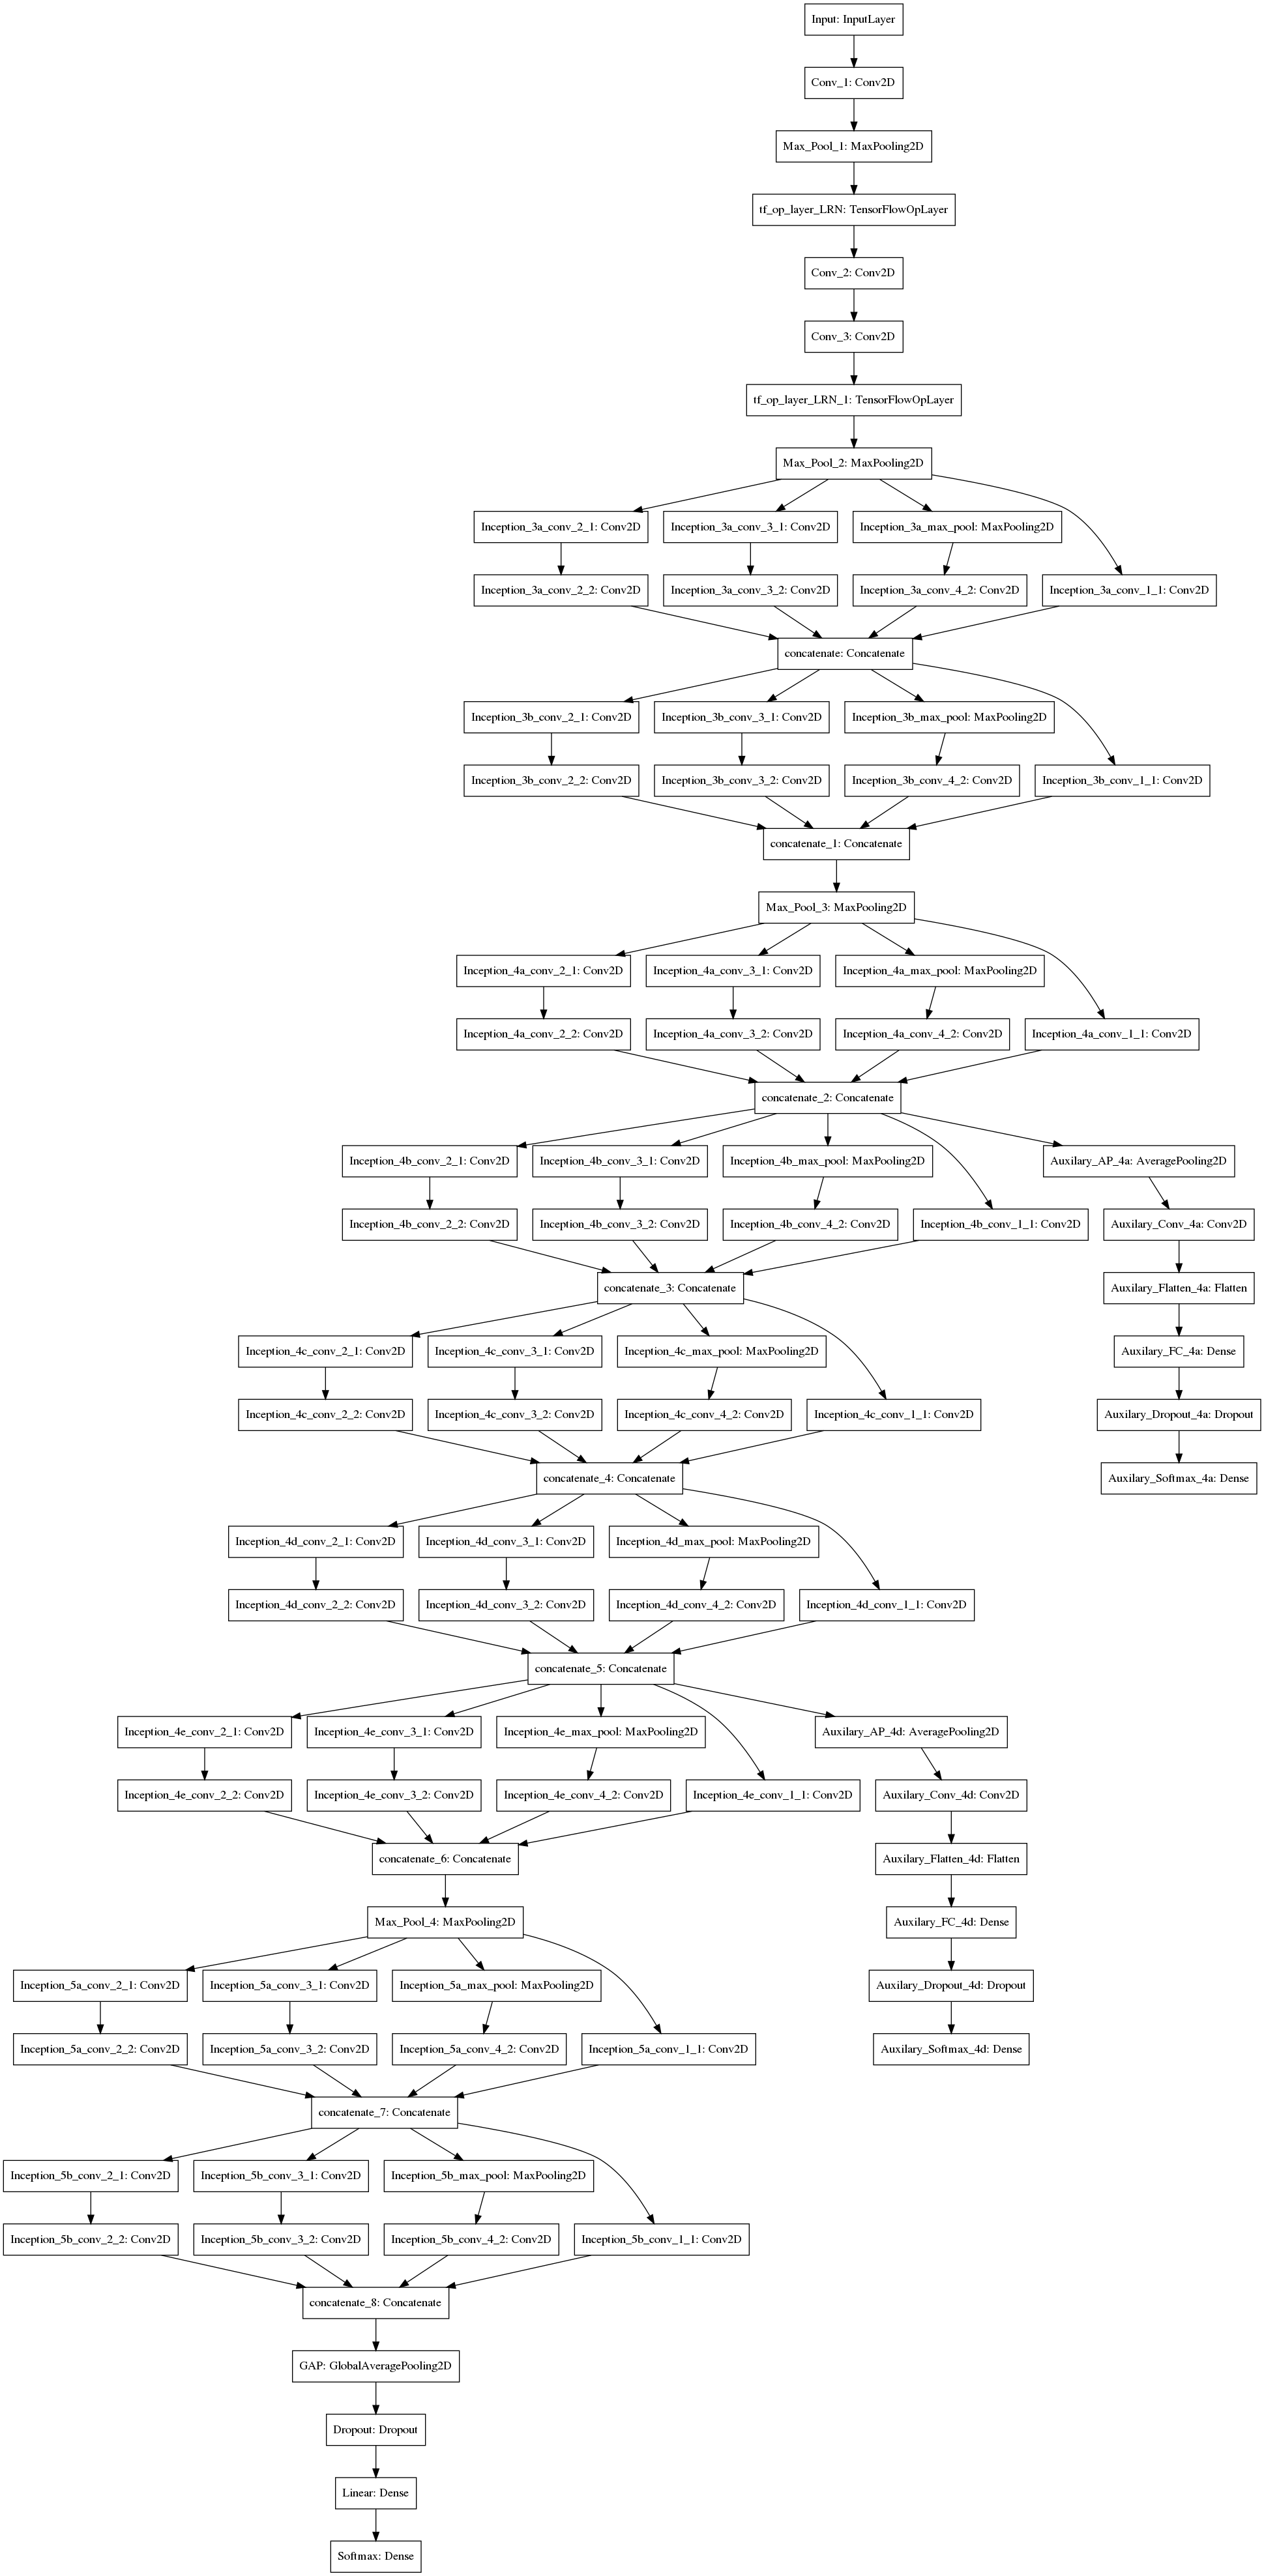

In [7]:
keras.utils.plot_model(GoogLeNet)

In [8]:
GoogLeNet.compile(loss={'base': 'categorical_crossentopy',
                        'auxiliary_4a': 'categorical_crossentopy',
                        'auxiliary_4d': 'categorical_crossentopy'},
                  loss_weights={'base': 1.0,
                                'auxiliary_4a': 0.3,
                                'auxiliary_4d': 0.3},
                  optimizer=keras.optimizers.SGD(momentum=0.9),
                  metrics=['accuracy'])